# Convolutional Neural Network & Classification:

#### -Akshay Ratnawat

The objective is to build an image classifier that is capable of properly identifying four different categories of image. 

The data consists of various train and test samples across the four categories of image. You will notice that the data for a specific category is a singular image that has been flipped, rotated, or slightly altered in some way. 

In [19]:
# Installing necessary packages
#!pip install tensorflow
#!pip install keras

In [90]:
# Importing the required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os, glob

from sklearn.metrics import accuracy_score

### 1. Data Processing: 

#### a) Use the "ImageDataGenerator()" class from keras.processing.image to build out an instance called "train_datagen" with the following parameters: 
1. rescale = 1./255
2. shear_range = 0.2
3. zoom_range = 0.2
3. horizontal_flip = True

In [132]:
# example of progressively loading images from file
from keras.preprocessing.image import ImageDataGenerator

# create generator
datagen = ImageDataGenerator(rescale = 1/255,
                            shear_range = 0.2,
                            zoom_range = 0.2,
                            horizontal_flip = True)

#### b) Building the training set
1. path (where training data is stored)
2. target_size = (64, 64)
3. batch_size = 32
4. class_mode = categorical 

In [133]:
train_ds = datagen.flow_from_directory('./data/dataset_train/',
                                             target_size=(64, 64),
                                             batch_size=32,
                                             class_mode='categorical')

Found 88 images belonging to 4 classes.


#### c) Take a look at your training set: 
1. What is the image shape of each training observation?
2. How many total classes do we need to predict on? 

In [134]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32, 4)


Thus we can see that there is a batch of 32 images with shape (64x64x3)

And there are 4 Classes of images that we want to classify

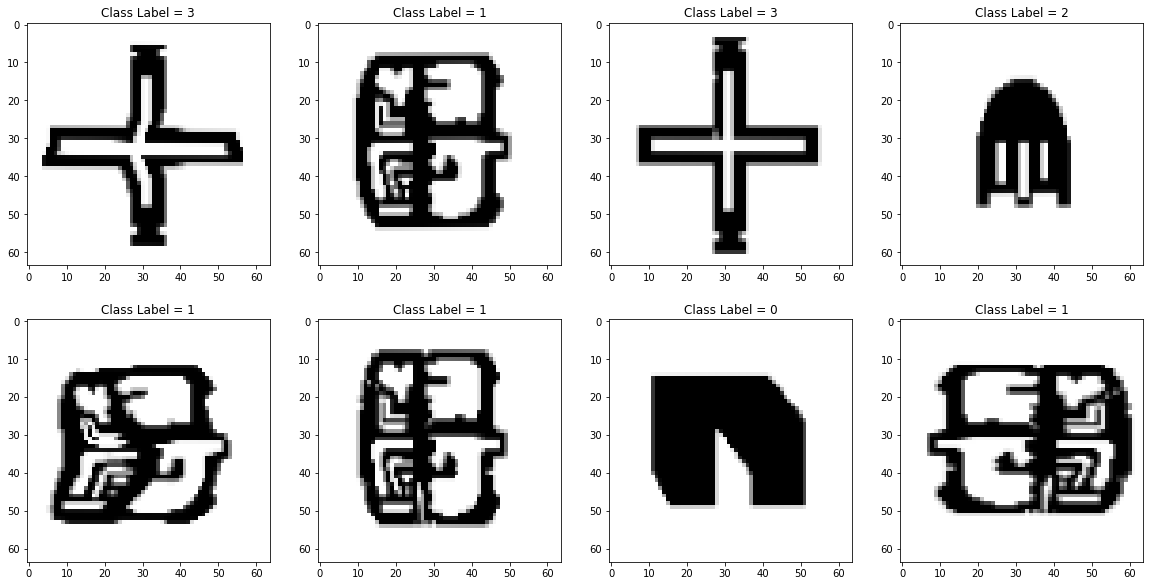

In [147]:
# Printing the images along with their labels
fig, axs = plt.subplots(2, 4, figsize=(20, 10));        
for i, ax in enumerate(axs.flatten()):
    img, label = train_ds.next()
    _ = ax.set_title(f'Class Label = {np.argmax(label[i])}');
    _ = ax.imshow(img[i]);

The above figure shows the different image categories and their labels as titles of each images in the dataset.

### 2. Initial Classifier Build: 

##### Pre-Processing data and optimizing CPU use

##### Create an instance of Sequential called "classifier"

In [148]:
# Creating the Model Class
num_classes = 4
input_shape = image_batch.shape

model = Sequential([
   # layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape[1:]),
    layers.Conv2D(filters=32, kernel_size=3, input_shape=input_shape[1:], activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=num_classes, activation='softmax')])

# Compiling the Model
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

1. Both, categorical cross entropy and sparse categorical cross entropy have the same loss function. The only difference is the format in which you mention Yi (i,e true labels).
2. If Yi's are one-hot encoded, we use categorical_crossentropy. For example (for a 3-class classification): [1,0,0], [0,1,0], [0,0,1]

3. But if Yi's are integers (which is in this case), we use sparse_categorical_crossentropy. For examples in the above 3-class classification problem: [1],[2],[3]

The usage entirely depends on how we load our dataset. Here since we did not loaded the data with one-hot encoding hence we will have to use Sparse Categorical Cross Entropy.

One advantage of using sparse categorical cross entropy is it saves time in memory as well as computation because it simply uses a single integer for a class, rather than a whole vector.

In [149]:
# Printing the Model Summary
model.summary()

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_106 (Dense)            (None, 128)               1605760   
_________________________________________________________________
dense_107 (Dense)            (None, 4)               

### 3. Model Runs: 
#### a) Use .fit() with the training set. For the first run, use the following parameters: 
1. steps_per_epoch = 3
2. epochs = 3

In [150]:
epochs=3
steps_per_epoch=3
model.fit(train_ds, steps_per_epoch=steps_per_epoch, epochs=epochs)

Epoch 1/3
3/3 [==============================] - 2s 304ms/step - loss: 6.5667 - accuracy: 0.3459
Epoch 2/3
3/3 [==============================] - 1s 305ms/step - loss: 2.7199 - accuracy: 0.3427
Epoch 3/3
3/3 [==============================] - 1s 312ms/step - loss: 1.0307 - accuracy: 0.7165


In [153]:
# To generate data when the input rans out of data we can use
epochs=3
steps_per_epoch=3
# loop through epochs
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    # loop through batches
    for x_batch, y_batch in datagen.flow_from_directory('data\dataset_train', target_size=(64, 64), batch_size = 32, class_mode = 'categorical', seed = 74):
            model.fit(x_batch, y_batch)
            batches += 1
            if batches >= steps_per_epoch:
                    break

Epoch 0
Found 88 images belonging to 4 classes.
1/1 [==============================] - 0s 439ms/step - loss: 0.1693 - accuracy: 1.0000
Epoch 1
Found 88 images belonging to 4 classes.
1/1 [==============================] - 0s 56ms/step - loss: 0.2635 - accuracy: 0.9167
Epoch 2
Found 88 images belonging to 4 classes.
1/1 [==============================] - 0s 60ms/step - loss: 0.0014 - accuracy: 1.0000


#### b) Save model to a file.

In [154]:
# save model
filename = str(1)+'my_model.h5'
model.save(filename)
print("Saved model")

Saved model


#### c) Predict using the model

In [155]:
# iterate over each test image
data_path = os.path.join("data/dataset_test", '*g')
files = glob.glob(data_path)

# make a prediction and add to results 
results = []
for f1 in files:
    img = image.load_img(f1, target_size = (64, 64))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    result = model.predict(img)
    r = np.argmax(result)
    results.append(r)

results

[0, 0, 1, 2, 1, 1, 1, 3]

#### d) Determine accuracy.

In [156]:
# Assigning the correct labels for the test data
test_label= [0, 0, 2, 2, 1, 1, 3, 3]

In [157]:
# Finding the accuracy of the model    
accuracy = accuracy_score(test_label, results)
accuracy

0.75

#### e) Run this process for the following combinations:
* (steps_per_epoch: 1, epochs: 1)
* (steps_per_epoch: 1, epochs: 2)
* (steps_per_epoch: 1, epochs: 3)
* (steps_per_epoch: 2, epochs: 4)
* (steps_per_epoch: 2, epochs: 5)
* (steps_per_epoch: 2, epochs: 6)
* (steps_per_epoch: 3, epochs: 7)
* (steps_per_epoch: 3, epochs: 8)
* (steps_per_epoch: 5, epochs: 9)
* (steps_per_epoch: 5, epochs: 10)

In [158]:
# Creating a Definition for fitting the model and saving it
def fit_save(model_number, epochs, steps_per_epochs):
    # Creating the Model Class
    num_classes = 4
    input_shape = image_batch.shape

    model = Sequential([
        layers.Conv2D(filters=32, kernel_size=3, input_shape=input_shape[1:], activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(units=128, activation='relu'),
        layers.Dense(units=num_classes, activation='softmax')])
    
    # Compiling the Model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])
    
    # Fitting the model
    epochs = epochs
    steps_per_epochs = steps_per_epochs
    
    # loop through epochs
    for e in range(epochs):
        print('Epoch', e)
        batches = 0
        # loop through batches
        for x_batch, y_batch in datagen.flow_from_directory('data\dataset_train', target_size=(64, 64), batch_size = 32, class_mode = 'categorical', seed = 74):
                history = model.fit(x_batch, y_batch)
                batches += 1
                if batches >= steps_per_epoch:
                        break

    # Storing the accuracy and loss for train and validation dataset
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    filename = str(model_number)+'my_model.h5'
    model.save(filename)
    return epochs, steps_per_epochs, acc, loss, filename 


# Creating the definition for getting the predicted test labels and calculating the accuracy of the model
def model_predict(model_name):
    # iterate over each test image
    data_path = os.path.join("data/dataset_test", '*g')
    files = glob.glob(data_path)

    # Loading the save model
    model = load_model(model_name)
    
    # make a prediction and add to results 
    results = []
    for f1 in files:
        img = image.load_img(f1, target_size = (64, 64))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis = 0)
        result = model.predict(img)
        r = np.argmax(result, axis=1)
        results.append(r)

    # Finding the accuracy of the model    
    accuracy = accuracy_score(test_label, results)
    
    return accuracy

In [159]:
# Checking the functions
epochs, steps_per_epochs, acc, loss, filename  = fit_save(model_number=1, epochs=5, steps_per_epochs=2)

Epoch 0
Found 88 images belonging to 4 classes.
1/1 [==============================] - 0s 354ms/step - loss: 7.8438 - accuracy: 0.1667
Epoch 1
Found 88 images belonging to 4 classes.
1/1 [==============================] - 0s 55ms/step - loss: 1.6151 - accuracy: 0.3333
Epoch 2
Found 88 images belonging to 4 classes.
1/1 [==============================] - 0s 56ms/step - loss: 0.9370 - accuracy: 0.9583
Epoch 3
Found 88 images belonging to 4 classes.
1/1 [==============================] - 0s 57ms/step - loss: 0.5279 - accuracy: 0.7083
Epoch 4
Found 88 images belonging to 4 classes.
1/1 [==============================] - 0s 60ms/step - loss: 0.0038 - accuracy: 1.0000


In [160]:
# Checking the functions
model_predict(model_name = filename )

0.875

In [144]:
# Creating a list of lost for storing the steps_per_epoch and Epochs for each iteration [steps_per_epoch, epoch]
iter_values = [[1,1], [1,2], [1,3], 
               [2,4], [2,5], [2,6], 
               [3,7], [3,8],
               [5,9], [5,10]]

# Intializing lists for storing the results
epochs_results= []
steps_per_epochs_results= []
acc_results= [] 
#val_acc_results= [] 
loss_results= [] 
#val_loss_results= [] 
accuracy_results= []

for i in iter_values:
    # Applying the fit definition and storing the results
    epochs, steps_per_epochs, acc, loss, filename = fit_save(model_number=i, epochs=i[1], steps_per_epochs=i[0])
    
    # Storing the results
    epochs_results.append(epochs)
    steps_per_epochs_results.append(steps_per_epochs)
    acc_results.append(acc)
    loss_results.append(loss)
    
    # Applying the predict definition and storing the accuracy
    accuracy = model_predict(model_name = filename)
    accuracy_results.append(accuracy)


3/3 [==============================] - 2s 315ms/step - loss: 6.0535 - accuracy: 0.1403
Epoch 1/2
3/3 [==============================] - 2s 315ms/step - loss: 8.6674 - accuracy: 0.2433
Epoch 2/2
3/3 [==============================] - 1s 316ms/step - loss: 3.5066 - accuracy: 0.2906
Epoch 1/3
3/3 [==============================] - 1s 254ms/step - loss: 13.2969 - accuracy: 0.1531
Epoch 2/3
3/3 [==============================] - 1s 225ms/step - loss: 2.0021 - accuracy: 0.2910
Epoch 3/3
3/3 [==============================] - 1s 214ms/step - loss: 1.1954 - accuracy: 0.6829
Epoch 1/4
3/3 [==============================] - 1s 256ms/step - loss: 15.9139 - accuracy: 0.2503
Epoch 2/4
3/3 [==============================] - 1s 250ms/step - loss: 1.1005 - accuracy: 0.5103
Epoch 3/4
3/3 [==============================] - 1s 215ms/step - loss: 0.5386 - accuracy: 0.8888
Epoch 4/4
3/3 [==============================] - 1s 220ms/step - loss: 0.4774 - accuracy: 0.8537
Epoch 1/5
3/3 [=======================

#### f) Create a final dataframe that combines the accuracy across each combination.

In [145]:
final_results = pd.DataFrame()
final_results['Epochs'] = epochs_results
final_results['Steps_Per_Epochs'] = steps_per_epochs_results
final_results['Accuracy'] = accuracy_results
final_results

,Epochs,Steps_Per_Epochs,Accuracy
0,1,1,0.500
1,2,1,0.375
2,3,1,0.750
3,4,2,0.875
4,5,2,0.750
5,6,2,0.875
6,7,3,0.750
7,8,3,0.750
8,9,5,0.625
9,10,5,0.750


#### Conceptual Questions: 

##### 4. Discuss the effect of the following on accuracy and loss (train & test): 
**Ans.**  
1. Increasing the steps_per_epoch
The Steps per epoch denote the number of batches to be selected for one epoch. Thus steps per epoch can help in reducing the noise of the gradient. Gradient of a single data point can be much more noisy than the gradient of a 100 Steps per epoch.

Further if we use the whole data in one Epoch, then it might get stuck in the local optimum. Using steps per epoch creates some noise in the data and this noise helps in jumping of the gradient out from the local minima.

2. Increasing the number of epochs:
When the number of epochs used to train a neural network model is more than necessary, the training model learns patterns that are specific to sample data to a great extent. This makes the model incapable to perform well on a new dataset. This model gives high accuracy on the training set (sample data) but fails to achieve good accuracy on the test set. In other words, the model loses generalization capacity by overfitting to the training data.

 

##### 5. Name two uses of zero padding in CNN.
**Ans.** Zero-padding refers to the process of symmetrically adding zeroes to the input matrix. Two uses of it are:
1. It is mostly used when the dimensions of the input need to be preserved in the output.
2. It is also used to avoid loosing information at the boundaries, e.g. when weights in a filter drop rapidly away from its center.

##### 6. What is the use of a 1 x 1 kernel in CNN? 
Ans. 1 X 1 kernel is highly useful in CNN to shrink, increase or keep same the number of channels in neural networks. We can use pooling to reduce the Height and Width of any output. But to reduce the Depth of the output especially when we have multiple channels then 1 x 1 kernel is useful.

It is also called as Network within the Network. It helps in incorporating non linearilty in the network.

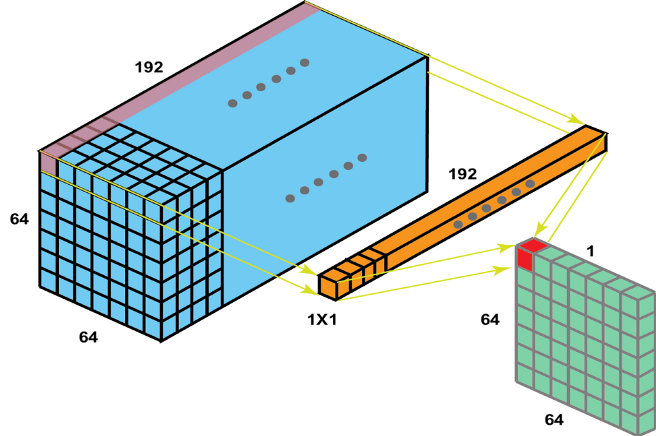

##### 7. What are the advantages of a CNN over a fully connected DNN for this image classification problem?
**Ans** Fully connected neural networks are good for classification, but they aren't good for feature extraction.

For Image classification problem we need to extract features from the images to build a good classifier. CNN through creation of Convolutional layer using filters helps in creating feature maps which helps in feature extraction from the image.

CNNs are trained to identify and extract the best features from the images. The latter layers of a CNN are fully connected because of their strength as a classifier. Thus CNN helps in creating better features and then these features at the end are passed through a fully connected layer for the classification problem.

Further CNN also reduces the overall parameters that need to be trained in comparison to creating a fully connected neural network. 